In [1]:
using SaddleSearch 
using SaddleSearch.TestSets
using Plots 
using Dierckx

In [2]:
V = LJVacancy2D(R = 5.1)
E, dE = objective(V)

X0 = copy(V.Xref); X1 = copy(V.Xref)
X0[:,1] *= 1.; X1[:,1] *= .0
x0 = X0[:, V.Ifree][:]
x1 = X1[:, V.Ifree][:]

P = SaddleSearch.TestSets.precond(V, x0)

# X = SaddleSearch.TestSets.dofs2pos(V, x0)
# plot(X[1,:], X[2,:], "b.")
# plot(X[1,V.Ifree], X[2,V.Ifree], "rx")

180×180 sparse matrix with 2736 Float64 nonzero entries:
	[1  ,   1]  =  367.022
	[31 ,   1]  =  -0.28125
	[33 ,   1]  =  -0.888889
	[35 ,   1]  =  -0.28125
	[47 ,   1]  =  -0.888889
	[49 ,   1]  =  -72.0
	[51 ,   1]  =  -72.0
	[53 ,   1]  =  -0.888889
	[65 ,   1]  =  -0.28125
	[67 ,   1]  =  -72.0
	⋮
	[177, 179]  =  -72.0
	[179, 179]  =  218.623
	[150, 180]  =  -0.28125
	[152, 180]  =  -0.888889
	[154, 180]  =  -0.28125
	[164, 180]  =  -0.888889
	[166, 180]  =  -72.0
	[168, 180]  =  -72.0
	[176, 180]  =  -0.28125
	[178, 180]  =  -72.0
	[180, 180]  =  218.623

In [3]:
# initial string 
N = 25
xstr =  [ (1-s) * x0 + s * x1  for s in linspace(0, 1, N) ]
s = linspace(0, 1, N); 

S = Array{Dierckx.Spline1D,2}(size(X0,2),2)
S[:] = [Spline1D(s*i, [xstr[j][i] for j=1:length(xstr)], w = ones(length(xstr)), k = 3, bc = "error") for i=1:length(xstr[1])]
# S = transpose(S)

Tstr = [[derivative(S[i,j], s) for j in 1:2, i in 1:size(X0,2)] for s in linspace(0., 1., N) ]
tstr = [Tstr[i]'[:] for i=1:N]
#[[derivative(S[i], s) for i in 1:length(X0)] for s in linspace(0., 1., N) ]

str = StringMethod(0.001, 1e-2, 200, I, (P, x) -> P, 2, false)
strP = StringMethod(0.01, 1e-3, 1600, P, (P, x) -> P, 2, true)

SaddleSearch.StringMethod
  alpha: Float64 0.01
  tol_res: Float64 0.001
  maxnit: Int64 1600
  precon: SparseMatrixCSC{Float64,Int64}
  precon_prep!: #15 (function of type ##15#16)
  verbose: Int64 2
  precon_cond: Bool true


In [4]:
STRx, STRlog = run!(str, E, dE, xstr, tstr)
# Tstr[:]=tstr

STRpx, STRplog = run!(strP, E, dE, xstr, tstr)
# Tstr[:]=tstr
# Xbb = SaddleSearch.TestSets.dofs2pos(V, xbb)
# plot(Xbb[1,:], Xbb[2,:], "b.")
# plot(Xbb[1,V.Ifree], Xbb[2,V.Ifree], "rx")

 nit |  sup|∇E|_∞   
-----|-----------------
   0 |   4.50e+01
   1 |   1.20e+01
   2 |   6.33e+00
   3 |   4.05e+00
   4 |   2.88e+00
   5 |   2.30e+00
   6 |   1.93e+00
   7 |   1.64e+00
   8 |   1.41e+00
   9 |   1.22e+00
  10 |   1.07e+00
  11 |   9.40e-01
  12 |   8.45e-01
  13 |   7.91e-01
  14 |   7.55e-01
  15 |   7.38e-01
  16 |   7.24e-01
  17 |   7.11e-01
  18 |   6.99e-01
  19 |   6.87e-01
  20 |   6.76e-01
  21 |   6.66e-01
  22 |   6.57e-01
  23 |   6.49e-01
  24 |   6.41e-01
  25 |   6.33e-01
  26 |   6.25e-01
  27 |   6.17e-01
  28 |   6.09e-01
  29 |   6.01e-01
  30 |   5.92e-01
  31 |   5.84e-01
  32 |   5.75e-01
  33 |   5.67e-01
  34 |   5.58e-01
  35 |   5.49e-01
  36 |   5.41e-01
  37 |   5.32e-01
  38 |   5.23e-01
  39 |   5.15e-01
  40 |   5.06e-01
  41 |   4.98e-01
  42 |   4.90e-01
  43 |   4.82e-01
  44 |   4.73e-01
  45 |   4.65e-01
  46 |   4.57e-01
  47 |   4.50e-01
  48 |   4.42e-01
  49 |   4.35e-01
  50 |   4.29e-01
  51 |   4.23e-01
  52 |   4.18e-01
 

(Array{Float64,1}[[-0.986115,9.07798e-14,-4.46159,0.859203,-3.96571,1.71746,-3.47022,2.57567,-2.97489,3.43425  …  2.97489,-3.43425,3.47022,-2.57567,3.96571,-1.71746,4.46159,-0.859203,4.95984,9.01082e-14],[-0.94917,7.71597e-14,-4.45365,0.858201,-3.95947,1.71609,-3.46659,2.57497,-2.97379,3.43505  …  2.9773,-3.43473,3.47075,-2.57518,3.96453,-1.71658,4.45945,-0.858597,4.9577,7.59191e-14],[-0.909154,5.21063e-14,-4.45025,0.857878,-3.95694,1.71574,-3.4655,2.5752,-2.97412,3.43642  …  2.9781,-3.43547,3.47026,-2.57516,3.96283,-1.71618,4.45706,-0.858268,4.95526,5.18906e-14],[-0.867339,3.11052e-14,-4.44819,0.857755,-3.95557,1.71585,-3.46519,2.57603,-2.97472,3.4383  …  2.97871,-3.4364,3.4699,-2.57543,3.96157,-1.71606,4.45526,-0.8581,4.95339,3.55155e-14],[-0.825084,4.92325e-14,-4.44686,0.857784,-3.95486,1.71625,-3.46533,2.57722,-2.97554,3.44047  …  2.97901,-3.43742,3.46939,-2.57585,3.96031,-1.71608,4.45354,-0.858009,4.95159,5.06444e-14],[-0.782329,2.11345e-14,-4.44557,0.857846,-3.95421,1.71676,-3.46

In [5]:
function instance(profile:: Array{Float64,1}, i::Int, colour)
  p = Plots.plot(profile)
  p = Plots.plot!(i:i, profile[i]:profile[i], marker=(10.0,:c), linestyle=:dot, linewidth=0, grid=false, color = colour)
  return p
end

instance (generic function with 1 method)

In [6]:
X = copy(V.Xref)
Xp = copy(V.Xref)

prof = [E(STRx[i]) for i=1:25]
profP = [E(STRpx[i]) for i=1:25]

anim = @animate for i =1 :25
  X[:] = STRx[i]
  Xp[:] = STRpx[i]
    
  p1 = Plots.plot(X[1,:], X[2,:], marker=(10.0,:+), linestyle=:dot, linewidth=0, color=:red,
    xlim=(-5.2,5.2), ylim=(-5,5))
#   p1 = Plots.plot!(X[1,V.Ifree], X[2,V.Ifree], marker=(15.0,:+), linestyle=:dot, linewidth=0, 
#                 xlim=(-5.2,5.2), ylim=(-5,5), size=(600, 600))
  p1 = Plots.plot!(Xp[1,:], Xp[2,:], marker=(10.0,:x), linestyle=:dot, linewidth=0, color = :darkcyan,
    xlim=(-5.2,5.2), ylim=(-5,5))
#   p1 = Plots.plot!(Xp[1,V.Ifree], Xp[2,V.Ifree], marker=(15.0,:+), linestyle=:dot, linewidth=0, 
#                 xlim=(-5.2,5.2), ylim=(-5,5), size=(600, 600))
    
  p2 = instance(prof, i, :red)
  p3 = instance(profP, i, :darkcyan)
  l = @layout [a{0.7h}; b{0.5w} c{0.5w}]
  p = Plots.plot(p1, p2, p3, layout=l, size=(600, 600))
    
end

Plots.gif(anim, fps=8)

sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
INFO: Saved animation to /Users/sMakri/GitHub/SaddleSearch.jl/examples/tmp.gif


Plots.AnimatedGif("/Users/sMakri/GitHub/SaddleSearch.jl/examples/tmp.gif")


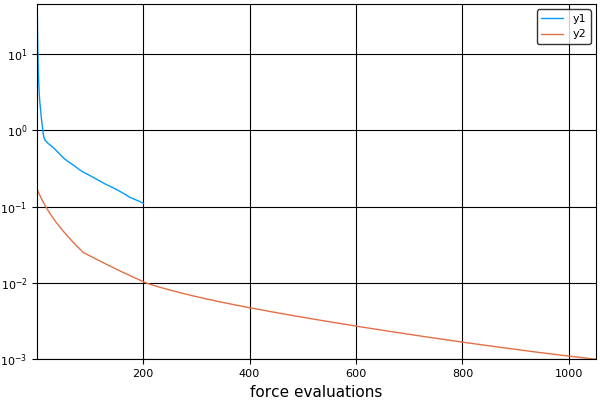

In [8]:
numdE = collect(STRlog[:numdE])
res = collect(STRlog[:maxres])
numdEp = collect(STRplog[:numdE])
resp = collect(STRplog[:maxres])
Plots.plot(numdE, res, yscale=:log10, xlabel="force evaluations")
Plots.plot!(numdEp, resp, yscale=:log10, xlabel="force evaluations")


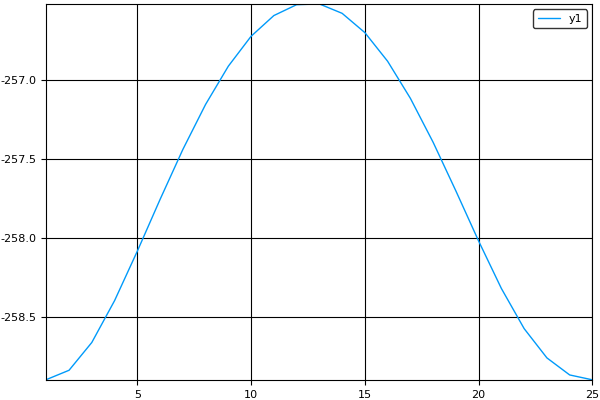

In [9]:
Plots.plot(profP)